In [1]:
import os
import gzip
import pickle
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import watchcbb.utils as utils
import watchcbb.efficiency as eff
import watchcbb.sql as sql

In [2]:
df_games = sql.df_from_query(""" SELECT * FROM game_data ORDER BY "Date" """)
df_games.head(10)

,Season,Date,gid,Type,WTeamID,WScore,LTeamID,LScore,Wrank,Lrank,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,poss
0,2011,2010-11-08,2010-11-08_california-irvine_illinois,RG,illinois,79,california-irvine,65,13,-1,...,14,22,11,26,12,14,7,1,21,74.90
1,2011,2010-11-08,2010-11-08_pittsburgh_rhode-island,RG,pittsburgh,83,rhode-island,75,5,-1,...,13,16,9,20,16,16,7,6,25,75.62
2,2011,2010-11-08,2010-11-08_navy_texas,RG,texas,83,navy,52,-1,-1,...,10,18,5,21,8,16,5,5,24,80.44
3,2011,2010-11-08,2010-11-08_maryland_seattle,RG,maryland,105,seattle,76,-1,-1,...,17,22,13,16,11,27,18,1,31,98.36
4,2011,2010-11-10,2010-11-10_louisiana-tech_texas,RG,texas,89,louisiana-tech,58,-1,-1,...,13,20,13,25,4,22,6,5,21,83.74
5,2011,2010-11-10,2010-11-10_college-of-charleston_maryland,RG,maryland,75,college-of-charleston,74,-1,-1,...,16,19,10,25,12,22,8,8,19,77.64
6,2011,2010-11-10,2010-11-10_illinois-chicago_pittsburgh,RG,pittsburgh,97,illinois-chicago,54,5,-1,...,7,9,5,15,9,11,0,3,18,67.88
7,2011,2010-11-10,2010-11-10_illinois_toledo,RG,illinois,84,toledo,45,13,-1,...,10,19,3,16,9,23,6,0,14,72.00
8,2011,2010-11-12,2010-11-12_long-island-university_norfolk-state,RG,long-island-university,87,norfolk-state,64,-1,-1,...,4,9,15,27,13,18,7,5,22,80.40
9,2011,2010-11-12,2010-11-12_mississippi-state_tennessee-state,RG,mississippi-state,75,tennessee-state,65,-1,-1,...,13,21,12,21,10,12,8,2,19,71.78


In [3]:
fname = 'cached/preseason_nb_season_stats.pkl.gz'
if os.path.exists(fname):
    with gzip.open(fname, 'rb') as fid:
        season_stats_df, season_stats_dict = pickle.load(fid)
else:
    season_stats_dict = utils.compute_season_stats(df_games)
    season_stats_df = utils.stats_dict_to_df(season_stats_dict)
    utils.add_advanced_stats(season_stats_df)
    season_stats_dict = utils.stats_df_to_dict(season_stats_df)
    eff.compute_efficiency_ratings(season_stats_dict)
    season_stats_df = utils.stats_dict_to_df(season_stats_dict)
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    with gzip.open(fname, 'wb') as fid:
        pickle.dump((season_stats_df, season_stats_dict), fid)

print(season_stats_df.shape)
season_stats_df[['year','team_id','wins','losses','Tneteff']].head()

(3497, 81)


,year,team_id,wins,losses,Tneteff
0,2011,air-force,15,15,5.814456
1,2011,akron,22,13,3.769233
2,2011,alabama,25,12,15.892420
3,2011,alabama-am,10,15,-16.968670
4,2011,alabama-birmingham,22,9,13.027349


## Get roster info

In [4]:
class Player():
    def __init__(self, ws=0, mp=0, exp=0):
        self.ws = ws
        self.mp = mp
        self.exp = exp

player_exp = defaultdict(int)
player_dict = {}
for year in season_stats_df.year.unique():
# for year in [2020]:
    player_dict[year] = {}
    roster_df = pd.read_pickle(f'../data/rosters/{year}.pkl.gz', compression='gzip').reset_index(drop=True)
    for irow,row in roster_df.iterrows():
        season_stats_dict[year][row.team_id]['players'] = row.players
        season_stats_dict[year][row.team_id]['player_WS'] = row.WS
        season_stats_dict[year][row.team_id]['player_MP'] = row.MP
        for i,pid in enumerate(row.players):
            player_exp[pid] += 1
            if pid not in player_dict[year]:
                player_dict[year][pid] = Player(ws=row.WS[i], mp=row.MP[i], exp=player_exp[pid])

season_stats_dict[2015]['purdue']['players']

['jonathan-octeus-1',
 'aj-hammons-1',
 'rapheal-davis-1',
 'vince-edwards-2',
 'kendall-stephens-1',
 'isaac-haas-1',
 'dakota-mathias-1',
 'basil-smotherman-1',
 'pj-thompson-1',
 'bryson-scott-1',
 'anfernee-brown-1',
 'neal-beshears-1',
 'john-mckeeman-1',
 'jacquil-taylor-1',
 'stephen-toyra-1']

## Get recruiting rankings

In [5]:
for year in season_stats_df.year.unique():
    df_espn = pd.read_csv(f'../data/recruit_ranks/espn_{year-1}.csv')
    df_rsci = pd.read_csv(f'../data/recruit_ranks/rsci_{year-1}.csv')
    for irow,row in df_espn.iterrows():
        season_stats_dict[year][row.team_id]['espn_recruit_rank'] = row.Rank
    for irow,row in df_rsci.iterrows():
        season_stats_dict[year][row.team_id]['rsci_recruit_rank'] = row.Rank
        season_stats_dict[year][row.team_id]['rsci_recruit_points'] = row.points
season_stats_dict[2018]['purdue']['rsci_recruit_points']

34

## Get win-shares lost each year

In [6]:
for year in season_stats_df.year.unique():
    if year-1 not in season_stats_dict:
        continue
    for tid in season_stats_dict[year]:
        if tid not in season_stats_dict[year-1]:
            continue
        if 'players' not in season_stats_dict[year][tid] or 'players' not in season_stats_dict[year-1][tid]:
            continue
        old_players = season_stats_dict[year-1][tid]["players"]
        new_players = season_stats_dict[year][tid]["players"]
        wshares = season_stats_dict[year-1][tid]["player_WS"]
        wshares_lost = 0.0
        wshares_return = 0.0
        wshares_transfer = 0.0
        for pid, ws in zip(old_players, wshares):
            if pid not in new_players:
                wshares_lost += ws
            else:
                wshares_return += ws
        
        ## very rough accounting for transfers:
        for pid in new_players:
            ## these players are probably grad transfers
            if pid not in old_players and pid in player_dict[year-1] and player_dict[year-1][pid].exp >= 3:
                wshares_transfer += player_dict[year-1][pid].ws
            ## these are probably non-grad transfers that have to sit out
            elif pid not in old_players and pid in player_dict[year-1] and player_dict[year-1][pid].exp > 0:
                pass
            ## the next two cover players that sat out for transfer/injury/etc and come back
            elif pid not in old_players and year-2 in player_dict and pid in player_dict[year-2]:
                wshares_transfer += player_dict[year-2][pid].ws
            elif pid in old_players and player_dict[year-1][pid].ws == 0.0 and year-2 in player_dict and pid in player_dict[year-2]:
                wshares_transfer += player_dict[year-1][pid].ws

        season_stats_dict[year][tid]["wshares_lost"] = wshares_lost
        season_stats_dict[year][tid]["wshares_return"] = wshares_return
        season_stats_dict[year][tid]["wshares_transfer"] = wshares_transfer

# season_stats_dict[2020]['purdue']

In [7]:
year_start = season_stats_df.year.min() + 2
data = defaultdict(list)
for year in range(year_start, season_stats_df.year.max()+1):
    for tid in season_stats_dict[year]:
        data['year'].append(year)
        data['tid'].append(tid)
        data['final_eff'].append(season_stats_dict[year][tid]["Tneteff"])
        data['yearm1_eff'].append(season_stats_dict[year-1].get(tid,{}).get("Tneteff",None))
        data['yearm2_eff'].append(season_stats_dict[year-2].get(tid,{}).get("Tneteff",None))
        data['wshares_lost'].append(season_stats_dict[year][tid].get('wshares_lost',None))
        data['wshares_return'].append(season_stats_dict[year][tid].get('wshares_return',None))
        data['wshares_transfer'].append(season_stats_dict[year][tid].get('wshares_transfer',None))
        data['espn_recruit_rank'].append(season_stats_dict[year][tid].get('espn_recruit_rank',None))
        data['rsci_recruit_rank'].append(season_stats_dict[year][tid].get('rsci_recruit_rank',None))
        data['rsci_recruit_points'].append(season_stats_dict[year][tid].get('rsci_recruit_points',0))
        
df = pd.DataFrame(data, columns=['year','tid','final_eff','yearm1_eff', 'yearm2_eff',
                                 'wshares_lost','wshares_return','wshares_transfer',
                                 'espn_recruit_rank','rsci_recruit_rank','rsci_recruit_points'])
df.loc[df.tid=='purdue']

,year,tid,final_eff,yearm1_eff,yearm2_eff,wshares_lost,wshares_return,wshares_transfer,espn_recruit_rank,rsci_recruit_rank,rsci_recruit_points
243,2013,purdue,10.191958,18.156229,28.141931,14.3,7.7,0.0,19.0,42.0,35
594,2014,purdue,9.686132,10.191958,18.156229,6.8,9.7,0.2,38.0,33.0,55
945,2015,purdue,17.805863,9.686132,10.191958,7.2,8.7,0.0,26.0,46.0,19
1296,2016,purdue,26.743148,17.805863,9.686132,5.8,15.8,1.4,23.0,25.0,85
1647,2017,purdue,26.661481,26.743148,17.805863,11.6,17.3,1.4,NaN,NaN,0
1998,2018,purdue,32.061396,26.661481,26.743148,8.1,19.8,0.3,NaN,40.0,34
2351,2019,purdue,30.008648,32.061396,26.661481,20.2,12.5,2.0,36.0,NaN,0
2705,2020,purdue,19.608672,30.008648,32.061396,13.8,13.7,4.9,NaN,NaN,0


In [8]:
df = df.dropna(subset=['yearm1_eff','yearm2_eff','wshares_lost','wshares_return','wshares_transfer'])

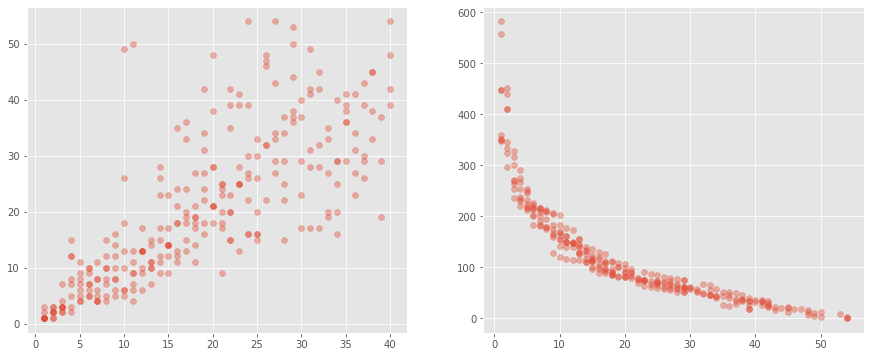

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
dfr = df[['espn_recruit_rank','rsci_recruit_rank','rsci_recruit_points']].dropna()
axs[0].scatter(dfr.espn_recruit_rank, dfr.rsci_recruit_rank, alpha=0.4)
axs[1].scatter(dfr.rsci_recruit_rank, dfr.rsci_recruit_points, alpha=0.4)

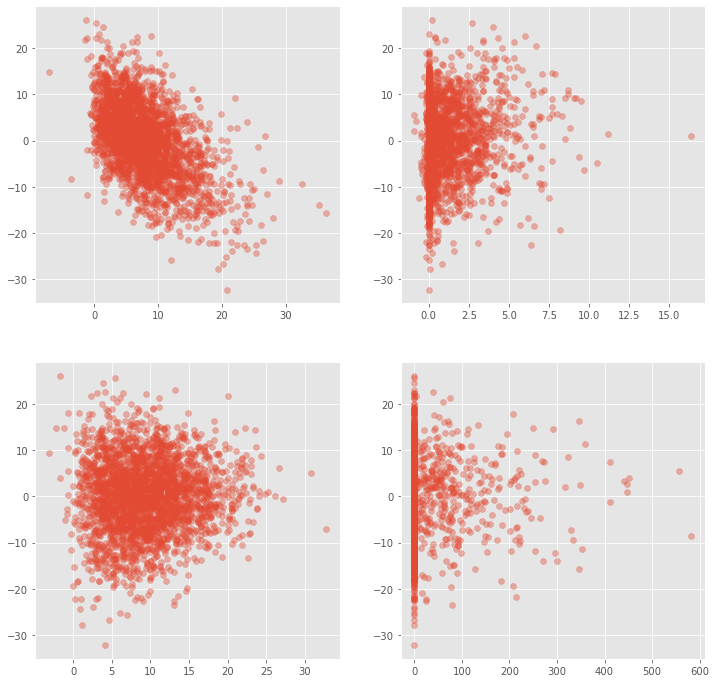

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
axs = axs.flatten()
dfr = df[['final_eff','yearm1_eff','wshares_lost','wshares_transfer','wshares_return','rsci_recruit_points']].dropna()
for i,col in enumerate(['wshares_lost','wshares_transfer','wshares_return','rsci_recruit_points']):
    axs[i].scatter(df[col], df.final_eff-df.yearm1_eff, alpha=0.4)

linreg_baseline [0.82347513] 0.057461892400025485
linreg1 [ 0.9475814  -0.9433484   1.11445666  0.03239513] 5.768783804997687
linreg2 [ 0.82735437  0.14964523 -0.91682203  1.00172908  0.02839107] 5.728482667585797
linreg_norecruit [ 0.84138307  0.17696471 -0.88067079  1.01854886] 5.840951773922305
linreg_notransfer [ 0.81987567  0.17942626 -0.88842544  0.02904234] 6.406639596791668
linreg_nolost [0.61161433 0.19640436 0.81225698 0.01905121] -0.9401031601016412
7.45 linreg_baseline
7.12 linreg_nolost
6.31 linreg_notransfer
6.25 linreg_norecruit
6.23 linreg1
6.20 xgb2
6.14 linreg2


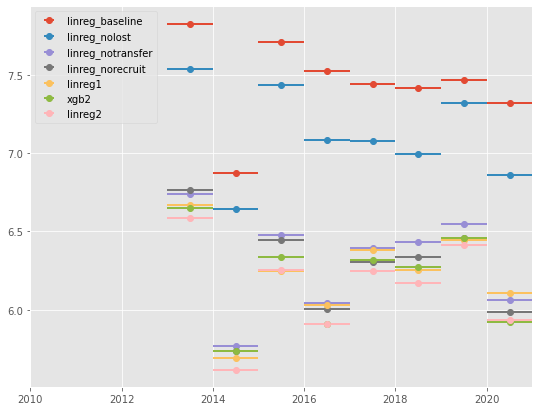

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

linreg = LinearRegression()

df['recruit_score'] = df.rsci_recruit_points
# df['recruit_score'] = df.espn_recruit_rank.fillna(100)
# df.recruit_score = 0.532/(df.recruit_score - 0.765)**0.436

df_tmp = df
# df_tmp = df.loc[df.rsci_recruit_points > 0]

models = {
    "linreg_baseline" : ['yearm1_eff'],
    "linreg1" : ['yearm1_eff','wshares_lost','wshares_transfer','recruit_score'],
    "linreg2" : ['yearm1_eff','yearm2_eff','wshares_lost','wshares_transfer','recruit_score'],
    "linreg_norecruit" : ['yearm1_eff','yearm2_eff','wshares_lost','wshares_transfer'],
    "linreg_notransfer" : ['yearm1_eff','yearm2_eff','wshares_lost','recruit_score'],
    "linreg_nolost" : ['yearm1_eff','yearm2_eff','wshares_transfer','recruit_score'],
    "xgb2" : ['yearm1_eff','yearm2_eff','wshares_lost','wshares_transfer','recruit_score'],
}
model_scores = defaultdict(list)
years = sorted(df.year.unique())
NVALID = 1
start_years = years[:len(years)-NVALID+1:NVALID]
for start_valid in start_years:
    valid_years = list(range(start_valid, start_valid+NVALID))
    train_years = sorted(set(years)-set(valid_years))
    
    for name,cols in models.items():
        X_train = df_tmp.loc[df.year.isin(train_years)][cols]
        y_train = df_tmp.loc[df.year.isin(train_years)].final_eff
        X_valid = df_tmp.loc[df.year.isin(valid_years)][cols]
        y_valid = df_tmp.loc[df.year.isin(valid_years)].final_eff
        
        if name.startswith('linreg'):
            model = linreg
        if name.startswith('xgb'):
            model = XGBRegressor(colsample_bytree=1, eval_metric='rmse', learning_rate=0.05, max_depth=2, 
                                 min_child_weight=15, n_estimators=250, objective='reg:squarederror', subsample=0.5)
        model.fit(X_train, y_train)
        pred = model.predict(X_valid)
        score = mean_squared_error(y_valid, pred)**0.5
#         score = mean_absolute_error(y_valid, pred)
        model_scores[name].append(score)
    
        if start_valid==2019 and name.startswith('linreg'):
            print(name,model.coef_, model.intercept_)

plt.figure(figsize=(9,7))
xs = np.array(start_years)
for name,scores in sorted(model_scores.items(), key=lambda x:np.mean(x[1]), reverse=True):
    print(f'{np.mean(scores):.2f} {name}')
    plt.errorbar(xs+NVALID/2.0, scores, xerr=NVALID/2.0, fmt='o', lw=2, label=name)
plt.gca().set_xlim(2010,2021)
plt.legend()

In [ ]:
from itertools import product
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

cols = ['yearm1_eff','yearm2_eff','wshares_lost','wshares_transfer','recruit_score']
train_years = [2013,2014,2015,2016,2017,2018]
valid_years = [2019,2020]
X_train = df.loc[df.year.isin(train_years)][cols]
y_train = df.loc[df.year.isin(train_years)].final_eff
X_valid = df.loc[df.year.isin(valid_years)][cols]
y_valid = df.loc[df.year.isin(valid_years)].final_eff

# for max_depth, n_estimators in product([2,3,4],[10,20,50,100]):
#     xgb = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators)
#     xgb.fit(X_train, y_train)
#     pred = xgb.predict(X_valid)
#     mse = mean_squared_error(y_valid, pred)**0.5
#     print(f'{max_depth:2d} {n_estimators:3d} {mse:.2f}')

parameters = {'objective':['reg:squarederror'],
              'eval_metric': ['rmse'],
              'learning_rate': [0.02,0.05,0.1], #so called `eta` value
              'max_depth': [2,3],
              'min_child_weight': [10,15,20],
              'subsample': [0.4,0.5,0.6],
              'colsample_bytree': [1],
              'gamma': [0],
              'n_estimators': [150,200,250,300,400]}
xgb = XGBRegressor()
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 3,
                        n_jobs = 4,
                        verbose=True)
xgb_grid.fit(X_train,
             y_train)

print(mean_squared_error(y_valid, xgb_grid.best_estimator_.predict(X_valid))**0.5)
print(xgb_grid.best_params_)

In [12]:
cols = ['yearm1_eff','yearm2_eff','wshares_lost','wshares_transfer','recruit_score']
# MODEL = LinearRegression()
MODEL = XGBRegressor(learning_rate=0.05, max_depth=2, min_child_weight=15, 
                     subsample=0.5, n_estimators=250, objective='reg:squarederror')
preds = []
for year in df.year.unique():
    train_years = sorted(set(df.year.unique())-set([year]))
    valid_years = [year]
    X_train = df.loc[df.year.isin(train_years)][cols]
    y_train = df.loc[df.year.isin(train_years)].final_eff
    X_valid = df.loc[df.year.isin(valid_years)][cols]
    y_valid = df.loc[df.year.isin(valid_years)].final_eff
    MODEL.fit(X_train.values, y_train)
    preds += MODEL.predict(X_valid.values).tolist()
df["pred_eff"] = preds

In [38]:
df.drop('dummy', axis=1).rename({'tid':'team_id'}, axis=1).to_csv('../data/preseason_predictions.csv')

0.0849235383589577


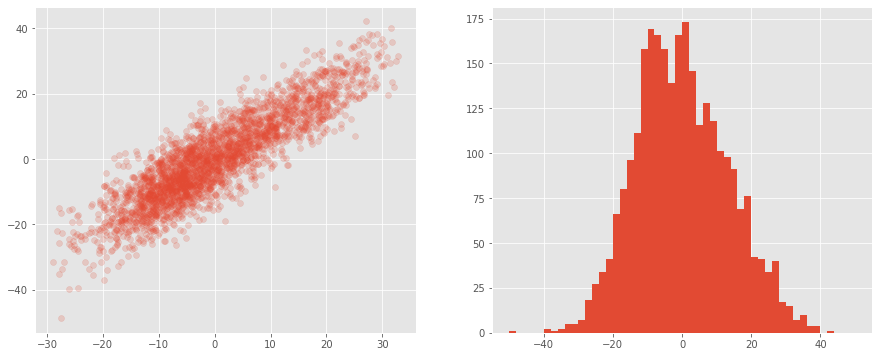

In [39]:
fig,axs = plt.subplots(1,2,figsize=(15,6))
axs[0].scatter(df.pred_eff, df.final_eff, alpha=0.2)
# plt.scatter(df.recruit_score, df.final_eff-df.pred_eff, alpha=0.2)
axs[1].hist(df.final_eff, bins=np.linspace(-50,50,51))
print(np.mean(df.pred_eff))

['dummy', 'yearm2_eff', 'wshares_lost', 'wshares_transfer', 'recruit_score']
['yearm1_eff', 'dummy', 'wshares_lost', 'wshares_transfer', 'recruit_score']
['yearm1_eff', 'yearm2_eff', 'dummy', 'wshares_transfer', 'recruit_score']
['yearm1_eff', 'yearm2_eff', 'wshares_lost', 'dummy', 'recruit_score']
['yearm1_eff', 'yearm2_eff', 'wshares_lost', 'wshares_transfer', 'dummy']


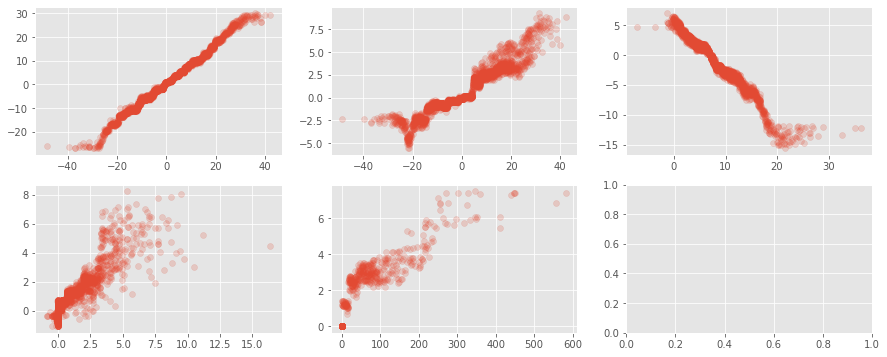

In [13]:
fig,axs = plt.subplots(2,3,figsize=(15,6))
axs = axs.flatten()
for i,c in enumerate(cols):
    df['dummy'] = df[c].median()
    cols_mod = list(cols)
    cols_mod[i] = 'dummy'
    print(cols_mod)
    X = df[cols]
    X_mod = df[cols_mod]
    pred = MODEL.predict(X.values)
    pred_mod = MODEL.predict(X_mod.values)
    axs[i].scatter(df[c], pred-pred_mod, alpha=0.2)

In [23]:
# ps = []
for FRAC in np.arange(0.05,0.96,0.05):
    first, second = utils.partition_games(df_games, frac=FRAC)
    season_stats_dict = utils.compute_season_stats(df_games.iloc[first])
    season_stats_df = utils.stats_dict_to_df(season_stats_dict)
    utils.add_advanced_stats(season_stats_df)
    season_stats_dict = utils.stats_df_to_dict(season_stats_df)
    param = 0.9 + 0.1*min(0.2,FRAC)/0.2
    eff.compute_efficiency_ratings(season_stats_dict, conv_param=param)
    season_stats_df = utils.stats_dict_to_df(season_stats_dict)
    df_merge = df.merge(season_stats_df[['year','team_id','Tneteff']], left_on=['year','tid'], right_on=['year','team_id'])
    df_merge = df_merge.loc[df_merge.Tneteff > -900]
    a = df_merge.pred_eff
    b = df_merge.Tneteff
    y = df_merge.final_eff
    p = -(a*b-b**2-a*y+b*y).sum() / ((a-b)**2).sum()
    print(FRAC, p)
    ps.append((FRAC,p))


0.05 0.882129830117826
0.1 0.8073989223151746
0.15000000000000002 0.663483497934354
0.2 0.5517400887971402
0.25 0.45986736893146374
0.3 0.3857260303668407
0.35000000000000003 0.31016294698399066
0.4 0.2614767491964545
0.45 0.21319694633706976
0.5 0.17387770598536673
0.55 0.14115750444674696
0.6000000000000001 0.10870610411906004
0.6500000000000001 0.08396879990628073
0.7000000000000001 0.07029921874819407
0.7500000000000001 0.0542354706523928
0.8 0.0386895725218578
0.8500000000000001 0.025828651876977124
0.9000000000000001 0.012653748532467401
0.9500000000000001 0.0065222854253595315


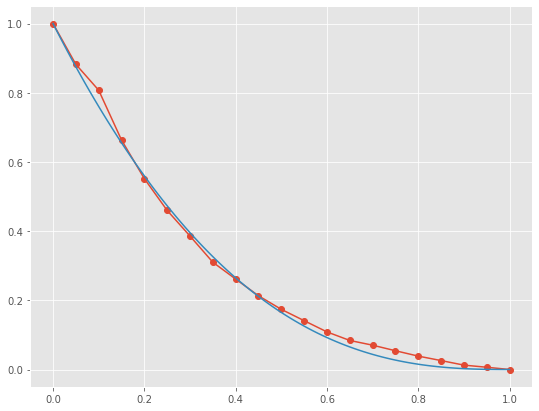

In [33]:
plt.figure(figsize=(9,7))
pvals = [x[1] for x in ps]
xs = np.linspace(0,1,101)
ys = (1-xs)**2.6
plt.plot(np.arange(0,1.01,0.05), [1]+pvals+[0], 'o-')
plt.plot(xs, ys, '-')